# Transforming Embracement

## Preliminaries

In [1]:
#prelims
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
from transformers import BertTokenizer
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
seaborn.set_context(context="talk")
%matplotlib inline

I0720 16:38:02.717482 47629321225088 file_utils.py:39] PyTorch version 1.5.1+cu101 available.


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Set up components

In [3]:
# embedding layer
#standard way to embed
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model
    def forward(self, x):
        return self.embed(x) * math.sqrt(self.d_model)

In [4]:
class PositionalEncoder(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, max_seq_len=5000, dropout=0.1):
        super(PositionalEncoder, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0., max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], #pe is 3 dimentional, so when we say self.pe[:, :x.size(1)] we set the x.size(1) to the rows of pe, but if x.size(1) is the column shape it will be wrong
                             requires_grad=False)
        return self.dropout(x)

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, ff_size, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.ff_size = ff_size
        self.fc1 = nn.Linear(self.d_model, self.ff_size)
        self.fc2 = nn.Linear(self.ff_size, self.d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        return self.fc2(self.dropout(F.leaky_relu(self.fc1(x))))

### Multi-Headed Attention

In [ ]:
class MultiHeadedAttention(nn.Module):
    '''
    We can think of attention as having a word (query) which we want to look up and find results for.
    K and V are considered our "memory" where we are looking for the most similar key to the query
    Once we find the most similar key, we get its value. Our "memory" is all of the previously generated words
    so when we pass in x,x,x we are DOT multiplying first word in x (q1) by all words in key, then get a scalar for each,
    then pass all scalars through softmax to get a score, then matmul by V to get the average attention vector for all words in x
    https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms
    '''
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h#size of model
        self.h = h#number of heads
        #could also be d_model, (n_heads * d_k)
        self.Wq = nn.Linear(d_model,d_model)
        self.Wk = nn.Linear(d_model,d_model)
        self.Wv = nn.Linear(d_model,d_model)
        self.out = nn.Linear(d_model,d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.attn_scores = None
    def forward(self,q,k,v, mask=None):
        '''Figure 2 of paper'''
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1).unsqueeze(2)
        nbatches = q.size(0)
        #1)Do all the linear projections in batch from d_model => h x d_k 
        #project entire model dimentions into h heads
        query = self.Wq(q).view(nbatches, -1, self.h, self.d_k).transpose(1,2)
        key = self.Wk(k).view(nbatches, -1, self.h, self.d_k).transpose(1,2)
        value = self.Wv(v).view(nbatches, -1, self.h, self.d_k).transpose(1,2)
        #2) Apply attention on all the projected vectors in batch. 
        z = self.attention(query, key, value, mask=mask, dropout=self.dropout)
        # 3) "Concat" using a view and apply a final linear. 
        z = z.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)#a little confused about what contiguous does
        return self.out(z)
    def attention(self, q,k,v, mask=None, dropout=None):
        'Scaled dot product attention'
        d_k = q.size(-1)#dimension of each head. We brok original input of 512 into 8 heads where each head is 64
        attn_scores = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_k)#transpose rows and col, where r => c and c=> r
        if mask is not None:#ultra important! as we should not attend to padding
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        '''a vector of scores, I believe it softmaxes across keys (words in translation) using same query. 
        meaning, it will do softmax for each key for every query to get how much attention we must pay to each word'''
        attn_scores = F.softmax(attn_scores, dim=-1)
        self.attn_scores = attn_scores
        if dropout is not None:
            attn_scores = dropout(attn_scores)
        
        return torch.matmul(attn_scores, v)# ,attn_scores #spits out z
    

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [9]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.!!!
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [10]:
'''
This layer just calculates self attention + add & norm. This is the first 2 sub blocks of the encoder
'''
class SelfAttentionLayer(nn.Module):
    def __init__(self, size, self_attn, dropout):
        super(SelfAttentionLayer, self).__init__()
        self.self_attn = self_attn
        self.size = size
        self.sublayer = SublayerConnection(size, dropout)
    def forward(self, x, mask):#this will be our own mask
        x = self.sublayer(x, lambda x: self.self_attn(x, x, x, mask))#first half, multihead attn + residual + sum. The lambda is for passing in the layer
        return x

### Cross-Modal Layers

In [11]:
'''
This layer calculates cross attention + add & norm + feedforward + add & norm. This is the Last 4 sub blocks of the decoder
'''
class CrossModalLayer(nn.Module):
    "Decoder block of a Transformer model."
    def __init__(self, size, cross_attn, feed_forward, dropout):
        super(CrossModalLayer, self).__init__()
        self.cross_attn = cross_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)#these sublayer connections are to create residual connections and layer normalization + dropout
        self.size = size
    #memory here is the key/val from another modality, opp_mod_mask: opposite modality mask
    def forward(self, x, memory, opp_mod_mask):
        x = self.sublayer[0](x, lambda x: self.cross_attn(x, memory, memory, opp_mod_mask))# src_mask == encoder-decoder attn
        x = self.sublayer[1](x, self.feed_forward)
        return x

In [12]:
class CrossModal(nn.Module):
    def __init__(self, layer, N):
        super(CrossModal, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, opp_mod_mask):#the memory here refers to the output of the encoder.
        for layer in self.layers:
            x = layer(x, memory, opp_mod_mask)
        return self.norm(x)

In [13]:
class Embracement(nn.Module):
    def __init__(self, size, p):
        super(Embracement, self).__init__()
        self.c = size
        self.p = nn.Parameter(torch.tensor(p))
    def forward(self,X_A, X_B):
        #make our random vector of size c and use it as a mask
        #r = torch.multinomial(torch.tensor(self.p), self.c, replacement=True).float().to(device)
        r = torch.multinomial(self.p, self.c, replacement=True).float().to(device)
        r1 = (r == 0.).float().clone().detach().to(device)
        r2 = (r == 1.).float().clone().detach().to(device)
        #Here we will filter the values
        d_prime1 = X_A*r1
        d_prime2 = X_B*r2
        d_prime = d_prime1 + d_prime2
        #multiply the 3 vectors together
        d_prime = d_prime * X_A * X_B
        x = d_prime.view(-1, self.c)
        #x = F.softmax(self.fc1(x), dim=0)
        return x#this is our z for both modalities

In [14]:
class TerminalNetwork(nn.Module):#output of model
    "Output layer + softmax"
    def __init__(self, d_model, n_out, dropout = 0.1):#takes in z size, outputs number of classes
        super(TerminalNetwork, self).__init__()
        self.hidden = nn.Linear(d_model, int(d_model/2))
        self.out = nn.Linear(int(d_model/2), n_out)#shape of embedding -> vocab size
        self.dropout = nn.Dropout(dropout)
        self.layernorm = LayerNorm(int(d_model/2))
    def forward(self, x):
        return self.out(self.dropout(self.layernorm(F.leaky_relu(self.hidden(x)))))
        #return self.out(x)#F.softmax(self.out(x), dim=-1)#output, Softmax is only needed for inference!

In [15]:
class BertImageEmbeddings(nn.Module):
    """Construct the embeddings from image, spatial location (omit now) and token_type embeddings.
    """

    def __init__(self, v_feature_size, v_hidden_size, hidden_dropout_prob):
        super(BertImageEmbeddings, self).__init__()

        self.image_embeddings = nn.Linear(v_feature_size, v_hidden_size)
        self.image_location_embeddings = nn.Linear(5, v_hidden_size)
        self.LayerNorm = LayerNorm(v_hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, input_ids, input_loc):

        img_embeddings = self.image_embeddings(input_ids)
        loc_embeddings = self.image_location_embeddings(input_loc)

        # TODO: we want to make the padding_idx == 0, however, with custom initilization, it seems it will have a bias.
        # Let's do masking for now
        embeddings = self.LayerNorm(img_embeddings + loc_embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings

In [16]:
#taken from vilbert
class BertTextPooler(nn.Module):
    def __init__(self, d_model):
        super(BertTextPooler, self).__init__()
        self.dense = nn.Linear(d_model, d_model)
        self.activation = nn.LeakyReLU()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:,0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


class BertImagePooler(nn.Module):
    def __init__(self, d_model):
        super(BertImagePooler, self).__init__()
        self.dense = nn.Linear(d_model, d_model)
        self.activation = nn.LeakyReLU()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:,0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

### Full model

In [17]:
'''
this is a nonsequential model, will have two cross modal blocks running at same time
I have to share the vector after the self attention portion, maybe within the model I get:
2 inputs, each input passes through its own self-attention -> add+norm, then get each vector, and pass it as
eachothers key & val as its 'memory', may have to make the module for the crossmodal block to have a 
self attention method and a cross attention module
'''

class MultimodalTransformer(nn.Module):
    "Full model definition"
    def __init__(self, self_attn_A, crossmodal_A, self_attn_B, crossmodal_B, embracement, terminal, embed_image, embed_text, img_pooler, txt_pooler):
        super(MultimodalTransformer, self).__init__()
        #cross modal transformer sub blocks
        self.self_attn_A = self_attn_A
        self.self_attn_B = self_attn_B
        self.crossmodal_A = crossmodal_A
        self.crossmodal_B = crossmodal_B
        self.embrace = embracement
        self.terminal = terminal
        self.embed_image = embed_image
        self.embed_text = embed_text
        self.img_pooler = img_pooler
        self.txt_pooler = txt_pooler
        
    def forward(self, x_a, x_b, X_A_mask, X_B_mask):#a and b are modalities A and B
        #perform self attention on modalities A and B
        
        a = self.embed_image(*x_a)
        b = self.embed_text(x_b)
        X_A = self.self_attn_A(a, X_A_mask)#remove Masks?!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        X_B = self.self_attn_B(b, X_B_mask)
        #perform cross modal attention
        X_A = self.crossmodal_A(X_A, X_B, X_B_mask)#modality A gets modality B as memory, no masks?
        X_B = self.crossmodal_B(X_B, X_A, X_A_mask)#modality B gets modality A as memory
        X_A = self.img_pooler(X_A)
        X_B = self.txt_pooler(X_B)
        #X_A = torch.mean(X_A, axis=1)
        #X_B = torch.mean(X_B, axis=1)#text input, maybe just use a special token?
        Z = self.embrace(X_A, X_B)#our embraced vector
        #Z = X_A*X_B#just multiply them
        return self.terminal(Z)#give us output

In [18]:
def gen_model(d_model = 128, ff_size = 128, src_vocab = 2000, n_out = 2, n_head = 1, Nx = 1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(n_head,d_model)
    ff = FeedForward(d_model, ff_size=ff_size)
    self_attn_A = SelfAttentionLayer(d_model, c(attn), 0.1)
    crossmodal_A = CrossModal(CrossModalLayer(d_model, c(attn), c(ff), dropout=0.1),Nx)
    
    self_attn_B = SelfAttentionLayer(d_model, c(attn), 0.1)
    crossmodal_B = CrossModal(CrossModalLayer(d_model, c(attn), c(ff), dropout=0.1),Nx)
    
    tn = TerminalNetwork(d_model, n_out)
    embracement = Embracement(d_model, [0.50,0.50])
    position = PositionalEncoder(d_model=d_model, dropout=0.1)#max_seq_len must be larger than the longest sequence!
    #embeddings are placed in sequential nn so we can train them, we also place the positional encoder so when we pass the input -> emb -> Pos
    embed_B = nn.Sequential(Embedder(src_vocab, d_model),c(position))#torch.rand(200, d_model)#this is temporary
    embed_A = BertImageEmbeddings(v_feature_size=1024, v_hidden_size=d_model, hidden_dropout_prob=0.1)#v_feature_size is fixed due to feature extractor
    
    txt_pooler = BertTextPooler(d_model)
    img_pooler = BertImagePooler(d_model)
    model = MultimodalTransformer(self_attn_A, crossmodal_A, self_attn_B, crossmodal_B, embracement,
                                  tn, embed_image=embed_A, embed_text=embed_B, img_pooler = img_pooler, txt_pooler=txt_pooler)

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

# Load data

Required Datasets (features must be extracted using the "RSNA Pneumonia" notebook from MIMIC-CXR-JPG prior to using):
 - MIMIC-CXR-JPG: https://physionet.org/content/mimic-cxr-jpg/2.0.0/
 - MIMIC-CXR (reports): https://physionet.org/content/mimic-cxr/2.0.0/

In [19]:
'''
Data comes from feature extractor & splits. Feature extractor gives features in .npy file (features, bbox, spatials, class, probs) and 
csv file containing:
    dicom_id
    feature_path
    report
    report_path
    Pneumonia/not Pneumonia

'''
#root dirs
root_dir = '/home/kl533/krauthammer_partition/Weights/transforming_embracement/'
mimic_loc = '/home/kl533/krauthammer_partition/mimic-cxr-jpg/mimic-cxr-jpg-2.0.0.physionet.org/'
#load csv into DF
df = pd.read_csv(os.path.join(root_dir, 'img_infos.csv'), index_col=0)
splits = pd.read_csv(os.path.join(mimic_loc, "mimic-cxr-2.0.0-split.csv"))

splits = splits[['dicom_id','split']]
df_splits = pd.merge(df, splits, on='dicom_id')
train = df_splits[df_splits['split']=='train']
validate = df_splits[df_splits['split']=='validate']
test = df_splits[df_splits['split']=='test']

#save dataframes into train, valid, test
train.to_csv('/home/kl533/krauthammer_partition/Weights/transforming_embracement/img_infos_TRAIN.csv')
validate.to_csv('/home/kl533/krauthammer_partition/Weights/transforming_embracement/img_infos_VALIDATE.csv')
test.to_csv('/home/kl533/krauthammer_partition/Weights/transforming_embracement/img_infos_TEST.csv')

### Our Dataset & DataLoader

In [20]:
class MIMIC_CXR_JPG_BBOX_FEATURES_Dataset(Dataset):
    """
    This dataset will be coming from already extracted features in .npy files.
    Args:
        csv_file (string): Contains information about original image and captions
        root_dir (string): location to .npy files
    """

    def __init__(self, csv_file, root_dir, max_seq_length=128, max_image_feats=128):
        self.max_image_feats = max_image_feats
        self.max_seq_length = max_seq_length#max length of tokens
        self.dataset_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.img_feats = pd.DataFrame(list(Path(root_dir).rglob("*.npy")), columns=['feature_path'])#list of features per image
        self.img_feats['feature_path'] = self.img_feats['feature_path'].apply(lambda x: str(x))
        self.img_feats['dicom_id'] = self.img_feats['feature_path'].apply(lambda x: os.path.basename(x).split('.')[0])
        self.dataset_frame = pd.merge(self.dataset_frame, self.img_feats, on='dicom_id')
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
        #one hot encode
        #target = self.dataset_frame.y
        self.n_classes = self.dataset_frame.y.nunique()

    def __len__(self):
        return len(self.dataset_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #load features from disk
        features = np.load(self.dataset_frame.iloc[idx]['feature_path'], allow_pickle=True).item()
        tokenized = self.tokenizer(text=self.dataset_frame.iloc[idx]['report'], add_special_tokens=True, max_length=self.max_seq_length,truncation=True,pad_to_max_length=True)
        text = torch.tensor(tokenized["input_ids"], dtype=torch.long)
        text_attn_mask = torch.tensor(tokenized["attention_mask"])
        #text_attn_mask = torch.stack([torch.tensor(text_attn_mask)], dim=0).squeeze(0)
        image_id = features['image_id']
        image_w = features['image_width']
        image_h = features['image_height']
        feature = torch.from_numpy(features['features'])
        num_boxes = features['num_boxes']
        g_feat = torch.sum(feature, dim=0) / num_boxes
        g_box = torch.tensor([[0.,0.,0.,0.]])
        num_boxes = num_boxes + 1
        feature = torch.cat([g_feat.view(1,-1), feature], dim=0)
        boxes = torch.from_numpy(features['bbox'])
        boxes = torch.cat([g_box,boxes])
        image_location = np.zeros((boxes.shape[0], 5), dtype=np.float32)
        image_location[:,:4] = boxes
        image_location[:,4] = (image_location[:,3] - image_location[:,1]) * (image_location[:,2] - image_location[:,0]) / (float(image_w) * float(image_h))
        image_location[:,0] = image_location[:,0] / float(image_w)
        image_location[:,1] = image_location[:,1] / float(image_h)
        image_location[:,2] = image_location[:,2] / float(image_w)
        image_location[:,3] = image_location[:,3] / float(image_h)
        g_location = np.array([0,0,1,1,1])
        image_location = np.concatenate([np.expand_dims(g_location, axis=0), image_location], axis=0)
        image_mask = [1] * (int(num_boxes))
        
        
        #the stacked features probably need to be padded!!!!!!!
        #padding added
        img_feat_padding = torch.zeros((self.max_image_feats-feature.size(0)),feature.size(1))
        img_attn_mask = torch.tensor([1]*len(feature) + [0]*len(img_feat_padding))
        #img_attn_mask = torch.stack([torch.tensor(img_attn_mask)], dim=0).squeeze(0)
        #print('img_attn_mask')
        #print(img_attn_mask)
        feature = torch.cat([feature, img_feat_padding], axis=0)
        features = torch.stack([feature], dim=0).float().squeeze(0)
        location = torch.tensor(image_location).float()
        location = torch.cat([location, torch.zeros(self.max_image_feats-location.size(0),location.size(1))], axis=0)
        #print(location)
        spatials = torch.stack([location], dim=0).float().squeeze(0)
        #image_mask = torch.stack([torch.tensor(image_mask)], dim=0).byte()
        bboxes = torch.cat([boxes, torch.zeros(self.max_image_feats-boxes.size(0),boxes.size(1))], axis=0)
        bboxes = torch.stack([bboxes], dim=0).float().squeeze(0)
        y = self.dataset_frame.iloc[idx]['y']
        output = {'features': features, 'spatials': spatials, 'text': text, 'boxes': bboxes, 
                  'image_id':image_id,'width':image_w, 'height':image_h, 'text_attn_mask':text_attn_mask, 'img_attn_mask':img_attn_mask,'y':y}

        return output#features, spatials, text, torch.tensor(y)

In [21]:
train_csv = os.path.join(root_dir, 'img_infos_TRAIN.csv')
valid_csv = os.path.join(root_dir, 'img_infos_VALIDATE.csv')
test_csv = os.path.join(root_dir, 'img_infos_TEST.csv')

mimic_feature_dataset_train = MIMIC_CXR_JPG_BBOX_FEATURES_Dataset(csv_file=train_csv,root_dir=root_dir, max_seq_length=512, max_image_feats=10)
mimic_feature_dataloader_train = DataLoader(mimic_feature_dataset_train, batch_size=24, shuffle=True, num_workers=4)

mimic_feature_dataset_valid = MIMIC_CXR_JPG_BBOX_FEATURES_Dataset(csv_file=valid_csv, root_dir=root_dir, max_seq_length=512, max_image_feats=10)
mimic_feature_dataloader_valid = DataLoader(mimic_feature_dataset_valid, batch_size=24, shuffle=False, num_workers=4)

mimic_feature_dataset_test = MIMIC_CXR_JPG_BBOX_FEATURES_Dataset(csv_file=test_csv, root_dir=root_dir, max_seq_length=512, max_image_feats=10)
mimic_feature_dataloader_test = DataLoader(mimic_feature_dataset_test, batch_size=24, shuffle=False, num_workers=4)

I0720 16:38:15.424336 47629321225088 tokenization_utils_base.py:1233] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/kl533/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0720 16:38:15.824843 47629321225088 tokenization_utils_base.py:1233] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/kl533/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0720 16:38:16.297834 47629321225088 tokenization_utils_base.py:1233] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/kl533/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df

### Generate a model with parameters

In [22]:
model = gen_model(src_vocab=mimic_feature_dataset_train.tokenizer.vocab_size, n_head=8, Nx=6, d_model=512, ff_size=2048)

In [23]:
#load model if you want
#net = Net()
#net.load_state_dict(torch.load(PATH))

In [24]:
model.embrace.p

Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)

In [25]:
'''attn_score = torch.rand(2,2,5,5)
attn_mask = torch.tensor([[1,1,1,0,0],[1,1,0,0,0]])
print(attn_score.size())
print(attn_score[0][0])
attn_mask = attn_mask.unsqueeze(1).unsqueeze(2)
print(attn_score.size())
### Cross attention
cross_attn_score = torch.rand(2,2,10,5)#(batch, head, txt_tokens, img_tokens), this is in the text decoders block
img_attn_mask = torch.tensor([[1,1,1,1,0],[1,0,0,0,0]])#b0: 4 feats, b1: 1 feat...
print(cross_attn_score[0][0])
print(cross_attn_score.size())
img_attn_mask = img_attn_mask.unsqueeze(1).unsqueeze(2)
cross_attn_score.masked_fill(img_attn_mask == 0, -1e9)'''

'attn_score = torch.rand(2,2,5,5)\nattn_mask = torch.tensor([[1,1,1,0,0],[1,1,0,0,0]])\nprint(attn_score.size())\nprint(attn_score[0][0])\nattn_mask = attn_mask.unsqueeze(1).unsqueeze(2)\nprint(attn_score.size())\n### Cross attention\ncross_attn_score = torch.rand(2,2,10,5)#(batch, head, txt_tokens, img_tokens), this is in the text decoders block\nimg_attn_mask = torch.tensor([[1,1,1,1,0],[1,0,0,0,0]])#b0: 4 feats, b1: 1 feat...\nprint(cross_attn_score[0][0])\nprint(cross_attn_score.size())\nimg_attn_mask = img_attn_mask.unsqueeze(1).unsqueeze(2)\ncross_attn_score.masked_fill(img_attn_mask == 0, -1e9)'

In [26]:
'''#Find learning rate. Not implemented yet
from torch_lr_finder import LRFinder
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(mimic_feature_dataloader_train, val_loader=mimic_feature_dataloader_valid, end_lr=1, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()'''

'#Find learning rate. Not implemented yet\nfrom torch_lr_finder import LRFinder\nlr_finder = LRFinder(model, optimizer, criterion, device="cuda")\nlr_finder.range_test(mimic_feature_dataloader_train, val_loader=mimic_feature_dataloader_valid, end_lr=1, num_iter=100, step_mode="linear")\nlr_finder.plot(log_lr=False)\nlr_finder.reset()'

# Train the Model

In [25]:
#Train
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=2)
for epoch in range(30):  # loop over the dataset multiple times
    torch.cuda.empty_cache()
    running_loss = 0.0
    val_loss = 0.0
    for i, data in enumerate(mimic_feature_dataloader_train, 0):
        # get the inputs;
        features = data['features'].to(device)
        spatials = data['spatials'].to(device)
        text = data['text'].to(device)
        labels = data['y'].to(device)
        img_attn_mask = data['img_attn_mask'].to(device)
        text_attn_mask = data['text_attn_mask'].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model([features, spatials], text, img_attn_mask, text_attn_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    #Check point each epoch
    PATH = '/home/kl533/krauthammer_partition/Weights/transforming_embracement/weights/transforming_embracement_leaky_varEMB_epoch_{}.pth'.format(epoch)
    torch.save(model.state_dict(), PATH)
    
    with torch.no_grad():
        for val_data in mimic_feature_dataloader_valid:
            val_features = val_data['features'].to(device)
            val_spatials = val_data['spatials'].to(device)
            val_text = val_data['text'].to(device)
            val_labels = val_data['y'].to(device)
            val_img_attn_mask = val_data['img_attn_mask'].to(device)
            val_text_attn_mask = val_data['text_attn_mask'].to(device)
            val_outputs = model([val_features, val_spatials], val_text, val_img_attn_mask, val_text_attn_mask)
            val_loss += criterion(val_outputs, val_labels)
    #reduce LR
    print('Validation loss: {}'.format(val_loss / len(mimic_feature_dataset_valid)))
    lr_scheduler.step(val_loss)

print('Finished Training')

[1,   100] loss: 0.917
[1,   200] loss: 0.681
[1,   300] loss: 0.507
[1,   400] loss: 0.359
[1,   500] loss: 0.339
[1,   600] loss: 0.298
[1,   700] loss: 0.310
[1,   800] loss: 0.283
[1,   900] loss: 0.282
[1,  1000] loss: 0.257
[1,  1100] loss: 0.247
[1,  1200] loss: 0.247
Validation loss: 0.013646476902067661
[2,   100] loss: 0.222
[2,   200] loss: 0.219
[2,   300] loss: 0.213
[2,   400] loss: 0.227
[2,   500] loss: 0.206
[2,   600] loss: 0.200
[2,   700] loss: 0.195
[2,   800] loss: 0.194
[2,   900] loss: 0.228
[2,  1000] loss: 0.201
[2,  1100] loss: 0.184
[2,  1200] loss: 0.190
Validation loss: 0.009639862924814224
[3,   100] loss: 0.164
[3,   200] loss: 0.139
[3,   300] loss: 0.165
[3,   400] loss: 0.162
[3,   500] loss: 0.172
[3,   600] loss: 0.157
[3,   700] loss: 0.176
[3,   800] loss: 0.160
[3,   900] loss: 0.169
[3,  1000] loss: 0.177
[3,  1100] loss: 0.141
[3,  1200] loss: 0.160
Validation loss: 0.01092276070266962
[4,   100] loss: 0.127
[4,   200] loss: 0.134
[4,   300] lo

# Test the Model

In [25]:
#Load weights
PATH = './weights/transforming_embracement_multiplied_leaky.pth'
model.load_state_dict(torch.load(PATH))
model.eval()
model.to('cuda')

MultimodalTransformer(
  (self_attn_A): SelfAttentionLayer(
    (self_attn): MultiHeadedAttention(
      (Wq): Linear(in_features=512, out_features=512, bias=True)
      (Wk): Linear(in_features=512, out_features=512, bias=True)
      (Wv): Linear(in_features=512, out_features=512, bias=True)
      (out): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sublayer): SublayerConnection(
      (norm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (self_attn_B): SelfAttentionLayer(
    (self_attn): MultiHeadedAttention(
      (Wq): Linear(in_features=512, out_features=512, bias=True)
      (Wk): Linear(in_features=512, out_features=512, bias=True)
      (Wv): Linear(in_features=512, out_features=512, bias=True)
      (out): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sublayer): SublayerConnection(
      (norm): LayerNorm()
      (dropout):

In [26]:
correct = 0
total = 0
label_list = []
output_list = []

with torch.no_grad():
    for data in mimic_feature_dataloader_test:
        features = data['features'].to(device)
        spatials = data['spatials'].to(device)
        text = data['text'].to(device)
        labels = data['y'].to(device)
        img_attn_mask = data['img_attn_mask'].to(device)
        text_attn_mask = data['text_attn_mask'].to(device)
        outputs = model([features, spatials], text,img_attn_mask, text_attn_mask)
        #outputs = model([torch.rand_like(features), torch.rand_like(spatials)], text, img_attn_mask, text_attn_mask)#noise
        #outputs = model([features, spatials], torch.randint_like(text, 30000), img_attn_mask, text_attn_mask)
        output_list.extend(outputs.tolist())
        label_list.extend(labels.tolist())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the {} test samples: {}'.format(len(mimic_feature_dataset_test), (100 * correct / total)))


Accuracy of the network on the 491 test samples: 89.20570264765784


In [27]:
#ohe = OneHotEncoder()
#label_list = ohe.fit_transform(np.asarray(label_list).reshape(-1, 1)).toarray()

In [27]:
fpr, tpr, thresholds = metrics.roc_curve(label_list, np.asarray(output_list)[:,1])
AUC = metrics.auc(fpr, tpr)

In [28]:
AUC

0.9507211538461539

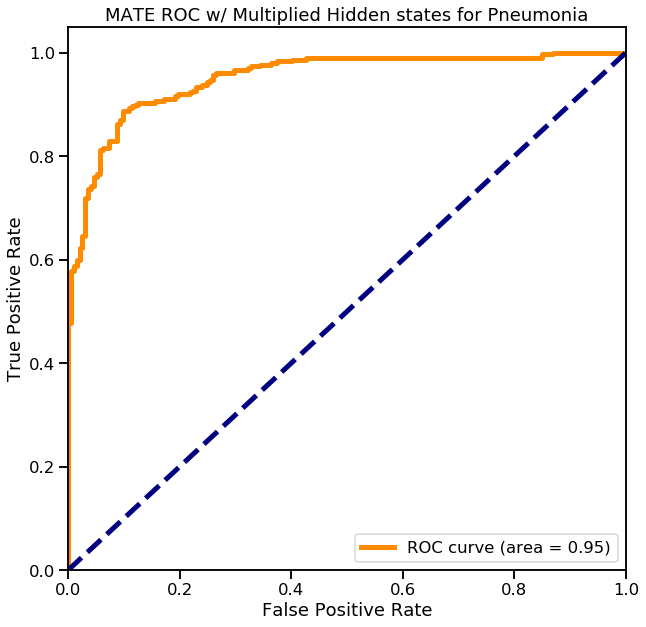

In [29]:
#Micro AUC because there is only one class!
plt.figure(figsize=(10,10))
lw = 5
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MATE ROC w/ Multiplied Hidden states for Pneumonia')
plt.legend(loc="lower right")
plt.show()

In [30]:
print(metrics.classification_report(label_list, np.argmax(F.softmax(torch.as_tensor(output_list), dim=1), axis=1).tolist()))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       192
           1       0.92      0.90      0.91       299

    accuracy                           0.89       491
   macro avg       0.89      0.89      0.89       491
weighted avg       0.89      0.89      0.89       491



In [31]:
precision = metrics.precision_score(label_list, np.argmax(output_list, axis=1))
print('Precision: %f' % precision)

Precision: 0.918367


In [32]:
metrics.precision_recall_fscore_support(label_list, np.argmax(output_list, axis=1), average='binary')

(0.9183673469387755, 0.903010033444816, 0.9106239460370994, None)

In [33]:
from collections import Counter
counts = Counter(zip(np.argmax(output_list, axis=1), label_list))

In [34]:
tp = counts[1,1]
tn = counts[0,0]
fp = counts[1,0]
fn = counts[0,1]

In [35]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))
print(precision)
print(recall)
print(f1)

0.9183673469387755
0.903010033444816
0.9106239460370994


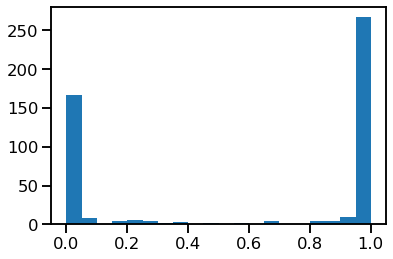

In [36]:
x = F.softmax(torch.as_tensor(output_list),dim=1)[:,1].tolist()
plt.hist(x, bins = 20)
plt.show()

In [38]:
#PATH = './weights/transforming_embracement_leaky.pth'
#torch.save(model.state_dict(), PATH)

In [87]:
PATH = './weights/transforming_NO_embracement_multiplied_leaky.pth'
model.load_state_dict(torch.load(PATH))
model.eval()
model.to('cuda')

MultimodalTransformer(
  (self_attn_A): SelfAttentionLayer(
    (self_attn): MultiHeadedAttention(
      (Wq): Linear(in_features=512, out_features=512, bias=True)
      (Wk): Linear(in_features=512, out_features=512, bias=True)
      (Wv): Linear(in_features=512, out_features=512, bias=True)
      (out): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sublayer): SublayerConnection(
      (norm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (self_attn_B): SelfAttentionLayer(
    (self_attn): MultiHeadedAttention(
      (Wq): Linear(in_features=512, out_features=512, bias=True)
      (Wk): Linear(in_features=512, out_features=512, bias=True)
      (Wv): Linear(in_features=512, out_features=512, bias=True)
      (out): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sublayer): SublayerConnection(
      (norm): LayerNorm()
      (dropout):

In [37]:
#only hear to find original files
df = pd.read_csv('mimic_outputs.csv', index_col=0)

In [38]:
with torch.no_grad():
    for i, batch in enumerate(mimic_feature_dataloader_test):
        features = batch['features'].to(device)
        spatials = batch['spatials'].to(device)
        text = batch['text'].to(device)
        labels = batch['y'].to(device)
        img_attn_mask = batch['img_attn_mask'].to(device)
        text_attn_mask = batch['text_attn_mask'].to(device)
        
        bboxs = batch['boxes']
        image_id = batch['image_id']
        width = batch['width']
        height = batch['height']
        if i > 3:
            #model.to(device)
            model.eval()
            outputs = model([features, spatials], text, img_attn_mask, text_attn_mask)
            _, predicted = torch.max(outputs.data, 1)
            break

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import matplotlib.cm as cm
#im_path = str(df[df['dicom_id'] == image_id[0]]['path'].values[0])
#im = np.array(Image.open(im_path), dtype=np.uint8)

def show_img():
    # Create figure and axes
    fig,ax = plt.subplots(1,figsize=(10,10))

    # Display the image
    ax.imshow(im)

    # Create a Rectangle patch
    max_val = max(head[token_num][idx])
    for ix, (box, score) in enumerate(zip(bboxs[idx], head[token_num][idx])):
        #print(box)
        x0,y0, x1, y1 = box     
        rect = patches.Rectangle((x0,y0),x1-x0,y1-y0,linewidth=3,edgecolor=cm.hot(score.item()/max_val),facecolor='none',label='float(score)', alpha = score.item()/max_val)
        
        ax.add_artist(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0
        ax.annotate('{0:.2f}'.format(score.item()) , (cx, cy), color='w', weight='bold', 
                    fontsize=12, ha='center', va='center')     
        
        # Add the patch to the Axes
        #ax.add_patch(rect)
    fig.colorbar(cm.ScalarMappable(cmap=cm.hot), ax=ax)
    plt.show()

In [40]:
import ipywidgets as widgets
from IPython.display import display, clear_output
img_num = 0
btn_clr = {'active':'lightgreen', 'inactive':'lightgray'}
#text
tokenizer = mimic_feature_dataset_test.tokenizer
txt = tokenizer.decode(text[img_num])
lookup = { v:k for (k,v) in enumerate(txt.split(' '))} 

#image
im_path = str(df[df['dicom_id'] == image_id[0]]['path'].values[0])
im = np.array(Image.open(im_path), dtype=np.uint8)
global boxes, target, layer_num, head_num, head
layer_num = 0
batch_num = 0
head_num = 0
boxes = []#init_buttons(txt)
bboxs = batch['boxes'][img_num]
global token_num
token_num = 0
head = model.crossmodal_B.layers[layer_num].cross_attn.attn_scores[img_num][head_num].cpu()

#functions
def dd_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        if change['new'] == 'Select Image':
            return 0
        global im, head, txt, lookup, boxes, bboxs, target, img_num
        img_num = change['new']
        im_path = str(df[df['dicom_id'] == image_id[img_num]]['path'].values[0])
        im = np.array(Image.open(im_path), dtype=np.uint8)
        head = model.crossmodal_B.layers[layer_num].cross_attn.attn_scores[img_num][head_num].cpu()
        txt = tokenizer.decode(batch['text'][img_num])
        lookup = { v:k for (k,v) in enumerate(txt.split(' '))}
        boxes = init_buttons(txt)
        btn_container.children = boxes
        bboxs = batch['boxes'][img_num]
        target.value="Ground Truth: {}, Predicted: {}".format(batch['y'][img_num], predicted[img_num])
        with output:
            clear_output()
            show_img()
            #display(target,widgets.GridBox(boxes, layout=widgets.Layout(grid_template_columns="repeat(10, auto)")))
def on_button_clicked(b):
    global idx, boxes, token_num
    tok_id = lookup[b.description]#looks up the word to get the token id        
    token_num = tok_id
    idx = (-head[token_num]).argsort().cpu()
    clear_output()
    #color red when selected!
    for i in range(len(boxes)):
        if boxes[i].description == b.description:
            boxes[i].style.button_color = btn_clr['active']
        else:
            boxes[i].style.button_color = btn_clr['inactive']
    btn_container.children = boxes
    with output:
        clear_output()
        show_img()
def init_buttons(txt):
    #set up buttons
    #text = set(txt.split(' '))
    boxes = []
    tokens = txt.split(' ')
    stopwords = ['[PAD]', '[SEP]', '_', ':', '.', ]
    tokens = set(tokens)
    tokens = [word for word in tokens if word not in stopwords]
    for token in tokens:
        b = widgets.Button(
            description=token,
            layout=widgets.Layout(width='auto'))
        b.style.button_color = 'lightgray'
        b.on_click(on_button_clicked)
        boxes.append(b)
    return boxes

def layerDD_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global layer_num, head, head_num
        layer_num = change['new']
        head = model.crossmodal_B.layers[layer_num].cross_attn.attn_scores[img_num][head_num].cpu()
        with output:
            clear_output()
            show_img()

def headDD_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global head_num, head, layer_num
        head_num = change['new']
        head = model.crossmodal_B.layers[layer_num].cross_attn.attn_scores[img_num][head_num].cpu()
        with output:
            clear_output()
            show_img()
#dropdown
dd = widgets.Dropdown(
    options=['Select Image']+[x for x in range(len(batch['y']))],
    description='Image:',
    disabled=False,
)

layerDD = widgets.Dropdown(
    options=[x for x in range(len(model.crossmodal_B.layers))],
    description='Layer:',
    disabled=False,
)
headDD = widgets.Dropdown(
    options=[x for x in range(len(model.crossmodal_B.layers[layer_num].cross_attn.attn_scores[img_num]))],
    description='Head:',
    disabled=False,
)

target = widgets.Label(value="Ground Truth: {}, Predicted: {}".format(batch['y'][img_num], predicted[img_num])
)
#output
output = widgets.Output()
dd_container = widgets.HBox(children=[dd, layerDD, headDD], layout=widgets.Layout(width='100%'))
btn_container = widgets.GridBox(boxes, layout=widgets.Layout(grid_template_columns="repeat(5, auto)"))
btn_fig_container = widgets.HBox(children=[btn_container, output], layout=widgets.Layout(height='700px'))
container = widgets.VBox(children=[dd_container,target,btn_fig_container])

#display
display(container)

dd.observe(dd_on_change,names = "value", type = "change")
layerDD.observe(layerDD_on_change,names = "value", type = "change")
headDD.observe(headDD_on_change,names = "value", type = "change")

In [73]:
print(layer_num)
print(head_num)
print(img_num)

0
6
23


In [31]:
model_ = gen_model(src_vocab=mimic_feature_dataset_train.tokenizer.vocab_size, n_head=2, Nx=2, d_model=10, ff_size=20)
a = torch.rand(10).to('cuda')
b = torch.rand(10).to('cuda')
c = model_.embrace(a, b)
print(a)
print(b)
print(c)

tensor([0.9640, 0.6248, 0.0131, 0.8533, 0.7309, 0.8748, 0.1154, 0.6604, 0.5496,
        0.2828], device='cuda:0')
tensor([0.9864, 0.8722, 0.8620, 0.6079, 0.0801, 0.7999, 0.4206, 0.2023, 0.6078,
        0.9604], device='cuda:0')
tensor([[0.9864, 0.6248, 0.8620, 0.6079, 0.0801, 0.7999, 0.4206, 0.2023, 0.6078,
         0.9604]], device='cuda:0')


In [55]:
try:
    assert 1 == 0, '1 == 1'
    print('works')
except Exception as e:
    print(e)
    print('doesnt work')

1 == 1
doesnt work
